# Age

Problem: "Age" has an effect on "Survived" & has a lot of "NaN"

**Goal: replace "NaN" with actual values that are better than "mean" values**

In [1]:
import pandas as pd
from sklearn import tree
from sklearn import model_selection
import graphviz

In [2]:
# SETTINGS
splits     = 5
repeats    = 5
param_grid = {"max_depth": [1, 2, 3, 4, 6],
              "max_leaf_nodes": [2, 4, 6, 8, 12, 16, 32],
              "min_samples_leaf": [1, 4, 16],
              "min_samples_split": [8, 16, 32]}

### REGRESSION
def select_regression_tree(X, y):
    param_grid["criterion"] = ["squared_error", "friedman_mse"]

    reg = model_selection.GridSearchCV(tree.DecisionTreeRegressor(random_state=1),
                                       param_grid,
                                       cv = model_selection.RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=2),
                                       n_jobs=4,
                                       verbose=1)

    reg.fit(X,y)
    print_result(reg)
    
    return reg


### CLASSIFICATION
def select_classification_tree(X, y):
    param_grid["criterion"] = ["entropy", "gini"]

    clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(random_state=1),
                                       param_grid,
                                       cv = model_selection.RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=2),
                                       n_jobs=4,
                                       verbose=1)

    clf.fit(X,y)
    print_result(clf)
    
    return clf


### PRINT RESULT
def print_result(model):
    print(model.best_score_.round(4))
    for name, value in model.best_params_.items():
        print("{}: {}".format(name, value))

---
## import data

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train_data.Age.head(25)

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5      NaN
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17     NaN
18    31.0
19     NaN
20    35.0
21    34.0
22    15.0
23    28.0
24     8.0
Name: Age, dtype: float64

In [6]:
train_data.Age.shape

(891,)

In [7]:
train_data.Age.isnull().sum()

177

---
## Option A: do not use "Age"

In [8]:
y = train_data.Survived
X = train_data[["Pclass", "Sex"]]

In [9]:
X

,Pclass,Sex
0,3,male
1,1,female
2,3,female
3,1,female
4,3,male
...,...,...
886,2,male
887,1,female
888,3,female
889,1,male


In [10]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

---
## one-hot encoding

In [11]:
X_0 = pd.get_dummies(X, columns=["Pclass", "Sex"])
X_0

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,0,1,0,1
1,1,0,0,1,0
2,0,0,1,1,0
3,1,0,0,1,0
4,0,0,1,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,1,0
888,0,0,1,1,0
889,1,0,0,0,1


In [12]:
clf = select_classification_tree(X_0, y)

Fitting 25 folds for each of 630 candidates, totalling 15750 fits
0.7868
criterion: entropy
max_depth: 1
max_leaf_nodes: 2
min_samples_leaf: 1
min_samples_split: 8


---
## get rid of redundant features

In [13]:
X_1 = X_0[["Pclass_1", "Pclass_3", "Sex_female"]]
X_1

,Pclass_1,Pclass_3,Sex_female
0,0,1,0
1,1,0,1
2,0,1,1
3,1,0,1
4,0,1,0
...,...,...,...
886,0,0,0
887,1,0,1
888,0,1,1
889,1,0,0


In [14]:
clf = select_classification_tree(X_1, y)

Fitting 25 folds for each of 630 candidates, totalling 15750 fits
0.7868
criterion: entropy
max_depth: 1
max_leaf_nodes: 2
min_samples_leaf: 1
min_samples_split: 8


---
## B: Use "Age" with mean values

In [15]:
train_data.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [16]:
train_data.Age.mean().round(6)

29.699118

In [17]:
ages = train_data[["Age"]].fillna(train_data.Age.mean())
ages

,Age
0,22.000000
1,38.000000
2,26.000000
3,35.000000
4,35.000000
...,...
886,27.000000
887,19.000000
888,29.699118
889,26.000000


In [18]:
X_2 = X_1.join(ages)
X_2

,Pclass_1,Pclass_3,Sex_female,Age
0,0,1,0,22.000000
1,1,0,1,38.000000
2,0,1,1,26.000000
3,1,0,1,35.000000
4,0,1,0,35.000000
...,...,...,...,...
886,0,0,0,27.000000
887,1,0,1,19.000000
888,0,1,1,29.699118
889,1,0,0,26.000000


In [19]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [20]:
clf = select_classification_tree(X_2, y)

Fitting 25 folds for each of 630 candidates, totalling 15750 fits
0.8005
criterion: entropy
max_depth: 4
max_leaf_nodes: 8
min_samples_leaf: 1
min_samples_split: 8


---
## improve prediction further by using a *better* "Age"

idea: using "Name", number of siblings & parents to approximate "Age"

occuring titles:
- [Mr](https://en.wikipedia.org/wiki/Mr.)
- Mrs
- Ms
- Master
- [Mlle](https://en.wikipedia.org/wiki/Mademoiselle_(title))
- Capt
- ...

In [21]:
train_data[["Name", "SibSp", "Parch", "Age"]].head(20)

,Name,SibSp,Parch,Age
0,"Braund, Mr. Owen Harris",1,0,22.0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,38.0
2,"Heikkinen, Miss. Laina",0,0,26.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,35.0
4,"Allen, Mr. William Henry",0,0,35.0
5,"Moran, Mr. James",0,0,NaN
6,"McCarthy, Mr. Timothy J",0,0,54.0
7,"Palsson, Master. Gosta Leonard",3,1,2.0
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,2,27.0
9,"Nasser, Mrs. Nicholas (Adele Achem)",1,0,14.0


In [22]:
def process_name(dataset):
    
    # split string to separate last_name and rest (= title + first name(s))
    separated_names = dataset.Name.apply(lambda x: x.split(", ")).to_list()
    
    # get last names
    last_names = [i[0] for i in separated_names]
    
    # split the rest
    rest = [i[1].split(". ") for i in separated_names]
    
    # get titles
    titles = [i[0].split(" ")[-1] for i in rest]
    
    # get first name(s) without any brackets
    first_names = [i[1].replace("(","").replace(")", "").split(" ") for i in rest]
    
    # get number of first names
    number_first_names = [len(i) for i in first_names]
    
    # add columns to dataset
    dataset["Title"] = titles
    dataset["LastName"] = last_names
    dataset["FirstNames"] = first_names
    dataset["NumberFirstNames"] = number_first_names
    
    return dataset    

In [23]:
train_data_2 = process_name(train_data)
sub_train_data_2 = train_data_2[["Age", "Title"]]
sub_train_data_2

,Age,Title
0,22.0,Mr
1,38.0,Mrs
2,26.0,Miss
3,35.0,Mrs
4,35.0,Mr
...,...,...
886,27.0,Rev
887,19.0,Miss
888,NaN,Miss
889,26.0,Mr


In [24]:
sub_train_data_2.Title.isnull().sum()

0

In [25]:
sub_train_data_2.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [26]:
sub_train_data_2 = pd.get_dummies(sub_train_data_2, columns=["Title"])
sub_train_data_2

,Age,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,38.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,26.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,35.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
887,19.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
888,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
889,26.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [27]:
sub_train_data_3 = sub_train_data_2.dropna()

In [28]:
sub_train_data_3

,Age,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,38.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,26.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,35.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,39.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
886,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
887,19.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
889,26.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [29]:
X_age = sub_train_data_3.drop(["Age"], axis=1)
y_age = sub_train_data_3.Age

In [30]:
clf_age = select_regression_tree(X_age, y_age)

Fitting 25 folds for each of 630 candidates, totalling 15750 fits
0.2687
criterion: squared_error
max_depth: 4
max_leaf_nodes: 6
min_samples_leaf: 16
min_samples_split: 8


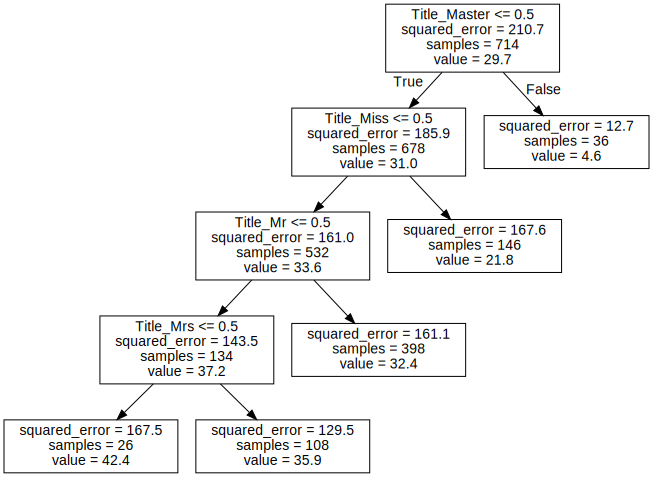

In [31]:
dot_data = tree.export_graphviz(clf_age.best_estimator_, out_file=None, 
                                feature_names=X_age.columns,
                                filled=False,
                                precision=1)
    
tree_plot = graphviz.Source(dot_data, format="svg")
tree_plot

In [32]:
X = sub_train_data_2.drop(["Age"], axis=1)

predicted_age = clf_age.predict(X)

In [33]:
sub_train_data_2["Age_pred"] = predicted_age

In [34]:
sub_train_data_2.head(20)

,Age,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Age_pred
0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
1,38.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
2,26.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21.773973
3,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
4,35.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
6,54.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
7,2.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.574167
8,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
9,14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148


In [35]:
sub_train_data_2.Age.fillna(sub_train_data_2.Age_pred, inplace=True)
sub_train_data_2.head(20)

,Age,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Age_pred
0,22.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
1,38.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
2,26.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21.773973
3,35.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
4,35.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
5,32.368090,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
6,54.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32.368090
7,2.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.574167
8,27.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
9,14.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,35.898148
